In [1]:
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

import os
import sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(ROOT_DIR)

from utils.utils import mse

from utils.problem import MitsubaProblem
from utils.problems.caustics import DoubleCausticProblem, CAUSTICS_SCENE_DIR

from utils.global_opt.grad import GlobalOptGrad, RandomStartGrad
from utils.global_opt.utils import IterationStoppingCriteria, NotImprovingStoppingCriteria

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.de import DE

mi.set_variant('cuda_ad_rgb')

In [2]:
config = {
    "render_resolution": (128, 128),
    "heightmap_resolution": (512, 512),
    "reference": os.path.join(CAUSTICS_SCENE_DIR, "references/sunday-128.exr"),
    "emitter": "bayer",
    'spp': 32,
    'max_iterations': 1000,
    'learning_rate': 3e-5,
}
double_pb = DoubleCausticProblem(config=config)

In [3]:
bm_ref = mi.Bitmap(config['reference'])
img_ref = mi.TensorXf(bm_ref)
bm_ref

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  metadata = {
    generatedBy => "Mitsuba version 3.0.1",
    pixelAspectRatio => 1,
    screenWindowWidth => 1
  },
  data = [ 192 KiB of image data ]
]

In [4]:
def scale_independent_loss(image, ref):
    """Brightness-independent L2 loss function."""
    scaled_image = image / dr.mean(dr.detach(image))
    scaled_ref = ref / dr.mean(ref)
    return dr.mean(dr.sqr(scaled_image - scaled_ref))

In [5]:
scene, params_scene = double_pb.initialize_scene()

# We will always apply displacements along the original normals and
# starting from the original positions.
positions_initial = dr.unravel(mi.Vector3f, params_scene['lens.vertex_positions'])
normals_initial   = dr.unravel(mi.Vector3f, params_scene['lens.vertex_normals'])

lens_si = dr.zeros(mi.SurfaceInteraction3f, dr.width(positions_initial))
lens_si.uv = dr.unravel(type(lens_si.uv), params_scene['lens.vertex_texcoords'])

In [6]:
initial_texture = mi.Bitmap(dr.zeros(mi.TensorXf, config["heightmap_resolution"]))
heightmap_texture = mi.load_dict({
    'type': 'bitmap',
    'id': 'heightmap_texture',
    'bitmap': initial_texture,
    'raw': True,
})
# Actually optimized: the heightmap texture
params = mi.traverse(heightmap_texture)
params.keep(['data'])

# Create optimizer
opt = mi.ad.Adam(lr=config['learning_rate'], params=params)

# opt = mi.ad.Adam(lr=config['learning_rate'])
# init_vector = np.zeros(single_pb.problem.n_var)
# heightmap_texture = single_pb.set_params_from_vector(opt, init_vector)

iterations = config['max_iterations']
loss_values = []
spp = config['spp']

for it in trange(iterations, desc='Iterations'):
    # Apply displacement and update the scene BHV accordingly
    double_pb.apply_transformations(params_scene, params, heightmap_texture=heightmap_texture)

    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=2 * spp, spp_grad=spp)

    # Scale-independent L2 function
    loss = scale_independent_loss(image, img_ref)
    # Back-propagate and take a gradient descent step
    dr.backward(loss)
    opt.step()
    
    # Carry over the update to our "latent variable" (the heightmap values)
    params.update(opt)
    loss_values.append(loss[0])
    
    # Increase rendering quality toward the end of the optimization
    if it in (int(0.7 * iterations), int(0.9 * iterations)):
        spp *= 2
        opt.set_learning_rate(opt.lr['data'] / 2)

Iterations: 100%|██████████| 1000/1000 [00:31<00:00, 32.14it/s]


In [7]:
def visualize_results(loss_values, params, image_ref, image):
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.style.use('dark_background')
    matplotlib.rc('figure', facecolor=(1, 1, 1, 0))
    matplotlib.rc('axes', facecolor=(1, 1, 1, 0.05))

    def show_image(ax, img, title):
        ax.imshow(mi.util.convert_to_bitmap(img))
        ax.axis('off')
        ax.set_title(title)
    def show_heightmap(fig, ax, cax, values, title):
        values = mi.util.convert_to_bitmap(params["data"]).convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)
        # values = params['data'].numpy()
        im = ax.imshow(values, vmax=1e-4)
        fig.colorbar(im, cax=cax)
        ax.axis('off')
        ax.set_title(title)

    fig, ax = plt.subplots(2, 3, figsize=(11, 10), 
                           gridspec_kw={'width_ratios': [0.5, 0.5, 0.02]})
    ax = ax.ravel()

    ax[0].plot(loss_values)
    ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Loss value'); 
    ax[0].set_title('Convergence plot')

    show_heightmap(fig, ax[1], ax[2], params['data'], 'Final heightmap')
    show_image(ax[3], image_ref, 'Reference')
    show_image(ax[4], image,     'Caustic image')
    ax[5].axis('off')
    fig.tight_layout()
    plt.show()

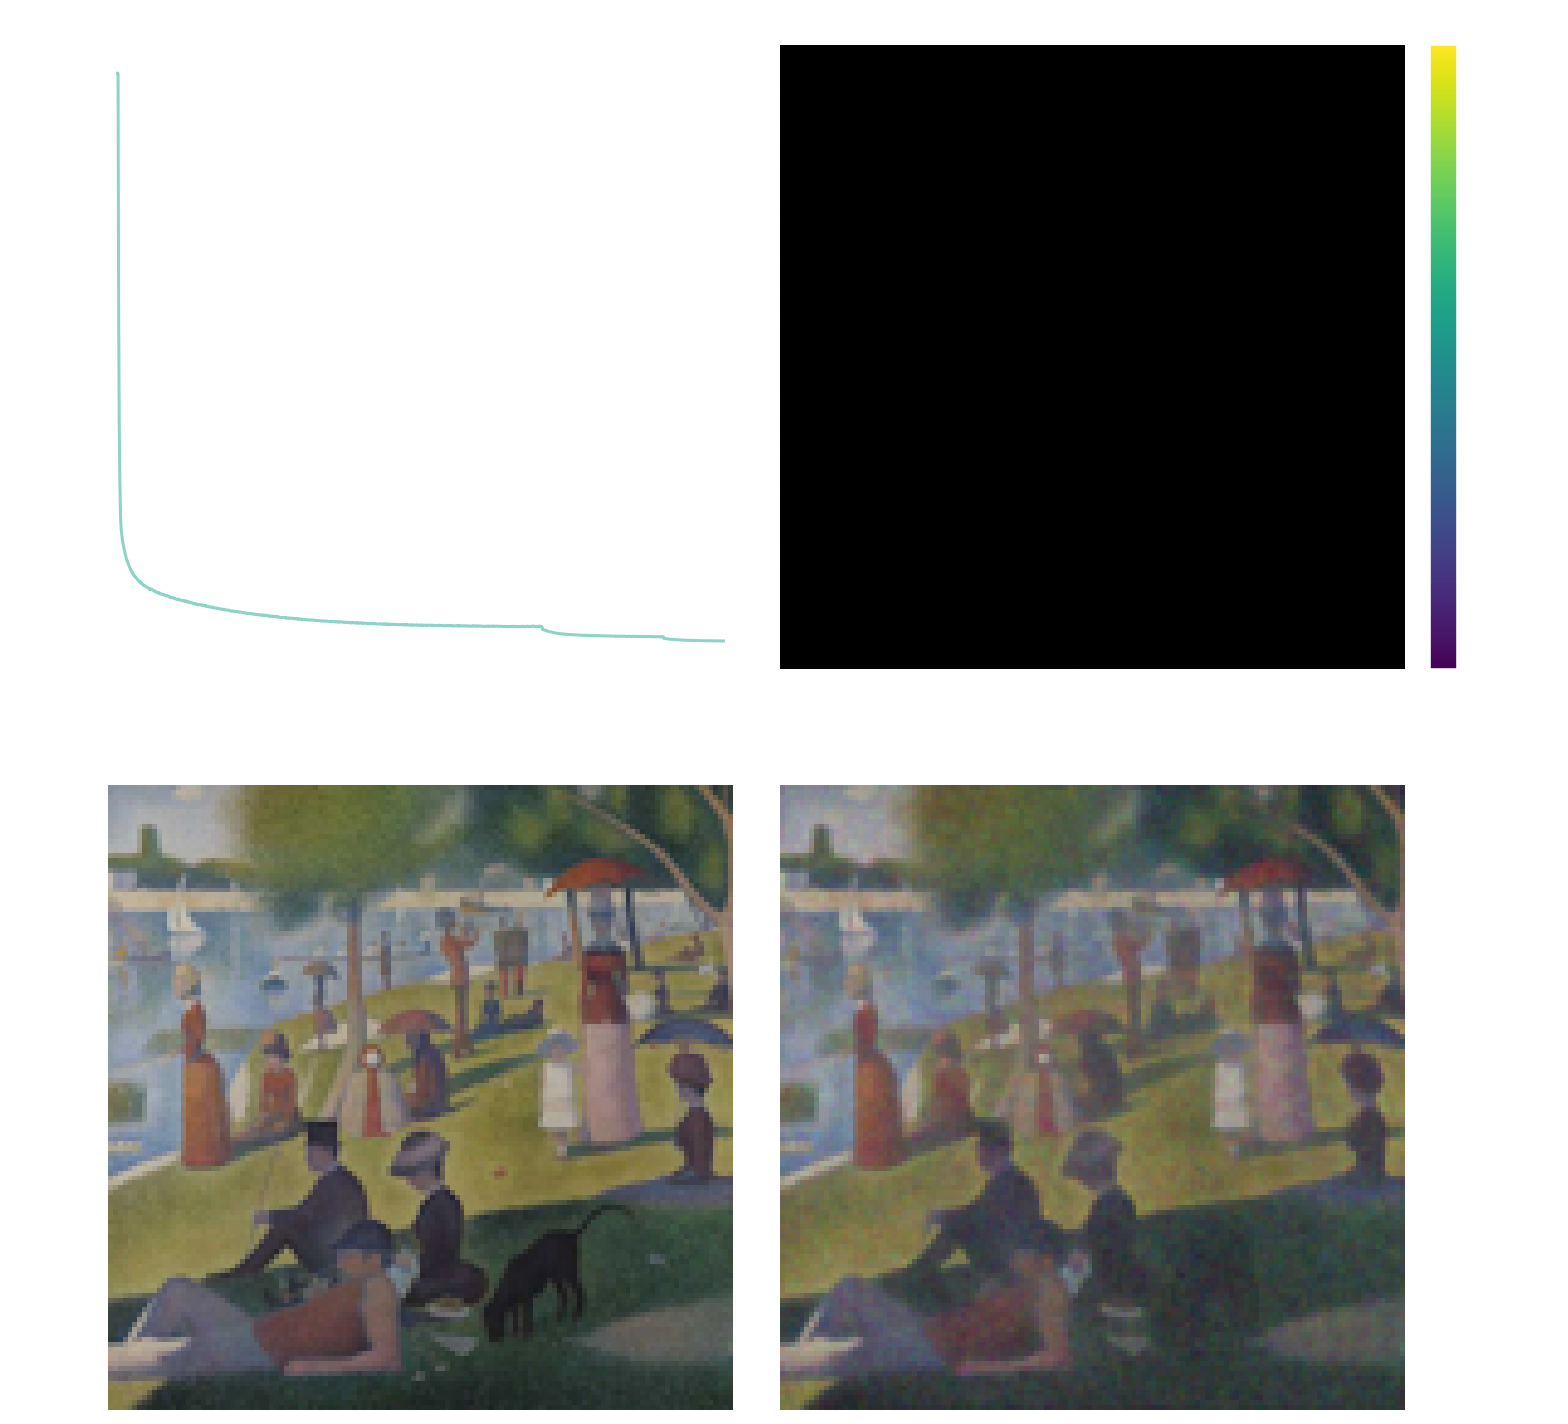

In [8]:
visualize_results(loss_values, params, img_ref, image)